
# Analyse des attaquants

Ce notebook constitue la **version finale** de l'analyse des attaquants (FW) bas√©e sur les donn√©es agr√©g√©es des cinq grands championnats europ√©ens (source : FBref).  
Il se concentre sur quatre axes, avec pour chacun :
- **Pourquoi on le fait** (objectif analytique),
- **M√©thode utilis√©e** (technique statistique/graphique),
- **Pourquoi c‚Äôest pertinent** (enjeux football & data),
- **Visualisations** (simples, interpr√©tables).




In [2]:

# Imports et chargement des donn√©es
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = "assembled_data_FW_normalized.csv"
df = pd.read_csv(CSV_PATH)
print("Lignes:", len(df), "| Colonnes:", len(df.columns))
df.head(5)


Lignes: 545 | Colonnes: 148


Rk              Player  Nation    Pos         Squad                Comp  \
0  2415        Aaron Seydel  de GER     FW  Darmstadt 98       de Bundesliga   
1   835     Abde Ezzalzouli  ma MAR     FW         Betis          es La Liga   
2  2202        Abde Rebbach  dz ALG  FW,MF        Alav√©s          es La Liga   
3  1274  Abdoul Kader Bamba  fr FRA  FW,MF        Nantes          fr Ligue 1   
4   755  Abdoulaye Doucour√©  ml MLI  FW,MF       Everton  eng Premier League   

    Age    Born MainPos  MP  ...  Subs_per_90  PPM_per_90  onG_per_90  \
0  27.0  1996.0      FW  16  ...     1.599354    0.072698    0.872375   
1  21.0  2001.0      FW  28  ...     1.929260    0.161576    1.061093   
2  24.0  1998.0      FW  23  ...     2.119114    0.087258    0.623269   
3  29.0  1994.0      FW  23  ...     3.240589    0.103110    1.178396   
4  30.0  1993.0      FW  32  ...     0.000000    0.049296    1.129707   

   onGA_per_90  +/-_per_90  +/-90_per_90  onxG_per_90  onxGA_per_90  \
0     2.180937   -1.308562     -0.190468     0.828756      1.962843   
1     0.868167    0.192926      0.137942     1.099678      1.225080   
2     0.747922   -0.124654     -0.014958     0.934903      0.847645   
3     2.504092   -1.325696     -0.195908     1.472995      2.356792   
4     1.232408   -0.102701     -0.003423     1.379612      1.430962   

   xG+/-_per_90  xG+/-90_per_90  
0     -1.134087       -0.165751  
1     -0.125402       -0.012540  
2      0.087258        0.011219  
3     -0.898527       -0.131097  
4     -0.051350       -0.001712  

[5 rows x 148 columns]


## 1) Inspection des colonnes & mappage s√©mantique

**Pourquoi ?** Comprendre la structure des donn√©es et identifier les colonnes cl√©s (buts, xG, tirs, assists...).  
**M√©thode :** inspection des noms de colonnes puis d√©tection ¬´ robuste ¬ª par recherche de motifs dans les noms (sans alias SQL).  
**Pertinence :** un bon mappage garantit des analyses coh√©rentes et reproductibles malgr√© les variations de nommage.


In [3]:

# Utilitaires de d√©tection de colonnes (robuste, sans alias SQL)
import re

def smart_find_column(df_columns, candidates=None, contains=None, regex=None):
    cols = list(df_columns)
    lcols = [c.lower() for c in cols]
    if candidates:
        cand_lower = [c.lower() for c in candidates]
        for i, lc in enumerate(lcols):
            if lc in cand_lower:
                return cols[i]
    if contains:
        contains_lower = [s.lower() for s in contains]
        for i, lc in enumerate(lcols):
            if any(s in lc for s in contains_lower):
                return cols[i]
    if regex:
        for i, lc in enumerate(lcols):
            if re.search(regex, lc):
                return cols[i]
    return None

def ensure_ratio_column(df, num_col, den_col, new_name):
    if num_col in df.columns and den_col in df.columns:
        with np.errstate(divide="ignore", invalid="ignore"):
            df[new_name] = np.where(df[den_col] > 0, df[num_col] / df[den_col], np.nan)
        return new_name
    return None


In [4]:

# Mappage des colonnes cl√©s (si pr√©sentes dans le CSV)
col_goals = smart_find_column(df.columns, candidates=["Goals","Gls"], contains=["goals","gls"])
col_xg = smart_find_column(df.columns, candidates=["xG"], contains=["xg","expected"])
col_shots_total = smart_find_column(df.columns, candidates=["Shots_Total","Sh"], contains=["shots_total","shots","sh"])
col_shots_on_target = smart_find_column(df.columns, candidates=["Shots_on_Target","SoT"], contains=["shots_on_target","sot","on_target"])
col_assists = smart_find_column(df.columns, candidates=["Assists","Ast"], contains=["assists","ast"])
col_xa = smart_find_column(df.columns, candidates=["xA"], contains=["xa","expected_assists"])
col_sca = smart_find_column(df.columns, candidates=["Shot_Creating_Actions","SCA"], contains=["shot_creating_actions","sca"])
col_gca = smart_find_column(df.columns, candidates=["Goal_Creating_Actions","GCA"], contains=["goal_creating_actions","gca"])
col_touches_in_box = smart_find_column(df.columns, contains=["touches_in_box","att_pen","penalty area","touches_att_pen"])
col_prgr = smart_find_column(df.columns, candidates=["Progressive_Passes_Received","PrgR"], contains=["progressive_passes_received","prgr"])
col_prgc = smart_find_column(df.columns, candidates=["Progressive_Carries","PrgC"], contains=["progressive_carries","prgc"])
col_pressures = smart_find_column(df.columns, candidates=["Pressures"], contains=["pressures"])
col_succ_pressures = smart_find_column(df.columns, contains=["successful_pressures","succ_press"])
col_tackles = smart_find_column(df.columns, candidates=["Tackles","Tkl"], contains=["tackles","tkl"])

gps_name = ensure_ratio_column(df, col_goals, col_shots_total, "Goals_per_Shot")
xgps_name = ensure_ratio_column(df, col_xg, col_shots_total, "xG_per_Shot")

core_cols = [c for c in [
    col_goals, col_xg, col_shots_total, col_shots_on_target, col_assists, col_xa,
    col_sca, col_gca, col_touches_in_box, col_prgr, col_prgc,
    col_pressures, col_succ_pressures, col_tackles, gps_name, xgps_name
] if c]

core_cols


['Gls',
 'xG',
 'Sh_shooting',
 'SoT',
 'Ast',
 'xA',
 'PrgR',
 'PrgC',
 'Tkld',
 'Goals_per_Shot',
 'xG_per_Shot']


## 2) Statistiques descriptives (rep√®res d‚Äô√©chelle)

**Pourquoi ?** Situer les grandeurs (m√©dianes, dispersion) pour √©viter des conclusions biais√©es.  
**M√©thode :** `describe()` sur les variables cl√©s.  
**Pertinence :** d√©tecte effectifs atypiques (tr√®s faibles minutes), distributions tr√®s asym√©triques, et pr√©pare les corr√©lations.


In [5]:

desc = df[core_cols].describe().T
desc


count        mean        std  min        25%        50%  \
Gls             545.0    5.040367   5.193872  0.0   1.000000   4.000000   
xG              545.0    4.792844   4.633280  0.0   1.400000   3.500000   
Sh_shooting     545.0   34.935780  26.625837  0.0  13.000000  31.000000   
SoT             545.0   13.313761  11.154772  0.0   4.000000  11.000000   
Ast             545.0    2.245872   2.492287  0.0   0.000000   1.000000   
xA              545.0    1.842936   1.863541  0.0   0.500000   1.200000   
PrgR            545.0  102.779817  77.360686  1.0  39.000000  88.000000   
PrgC            545.0   36.205505  36.213343  0.0  10.000000  23.000000   
Tkld            545.0   21.001835  18.631340  0.0   7.000000  16.000000   
Goals_per_Shot  534.0    0.154074   0.256661  0.0   0.071429   0.120000   
xG_per_Shot     534.0    0.128832   0.055670  0.0   0.087932   0.123077   

                       75%     max  
Gls               7.000000   36.00  
xG                6.400000   30.60  
Sh_shooting      51.000000  141.00  
SoT              20.000000   61.00  
Ast               3.000000   13.00  
xA                2.700000   11.00  
PrgR            149.000000  508.00  
PrgC             51.000000  184.00  
Tkld             31.000000  101.00  
Goals_per_Shot    0.181818    3.00  
xG_per_Shot       0.158130    0.35


## 3) Efficacit√© de tir vs Volume de tirs

**Pourquoi on le fait ?**  
√âvaluer si **tirer plus** (volume) est synonyme de **marquer plus** (output) et v√©rifier la **coh√©rence** avec la qualit√© des occasions (*xG*).

**M√©thode utilis√©e :**  
- **Matrice de corr√©lations (Pearson)** sur `Tirs`, `Tirs cadr√©s`, `Buts`, `xG`, `Buts/Tir`, `xG/Tir`.  
- **Scatter plots** pour observer la relation lin√©aire et les outliers (*sur/sous-performers*).  
Les corr√©lations sont calcul√©es uniquement sur valeurs num√©riques (NaN ignor√©s).

**Pourquoi c‚Äôest pertinent ?**  
- Valide l‚Äôalignement entre **production** (buts) et **qualit√© des occasions** (xG).  
- Rep√®re les profils **hyper-efficaces** (conversion au-dessus des attentes) vs **gros volume peu efficace**.


In [6]:

def corr_heatmap(df, columns, title):
    sel = [c for c in columns if c in df.columns]
    if len(sel) < 2:
        print(f"[Info] Pas assez de colonnes pour {title}. Colonnes trouv√©es:", sel)
        return None
    corr = df[sel].corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(corr.values, aspect='auto')
    ax.set_xticks(range(len(sel)))
    ax.set_yticks(range(len(sel)))
    ax.set_xticklabels(sel, rotation=45, ha='right')
    ax.set_yticklabels(sel)
    plt.title(title)
    plt.colorbar(im)
    # annotations
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center")
    plt.tight_layout()
    plt.show()
    return corr

def scatter_plot(df, x, y, title):
    if x in df.columns and y in df.columns:
        plt.figure(figsize=(6,5))
        plt.scatter(df[x], df[y])
        plt.xlabel(x); plt.ylabel(y)
        plt.title(title)
        plt.tight_layout()
        plt.show()


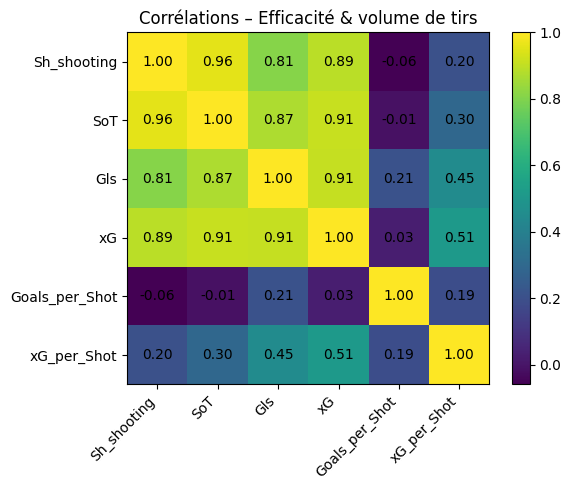

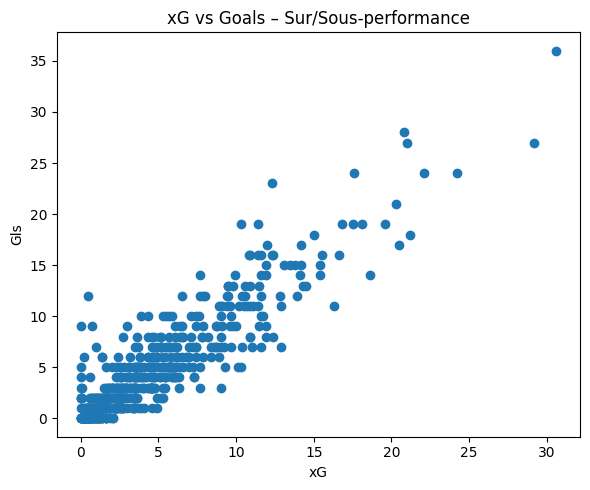

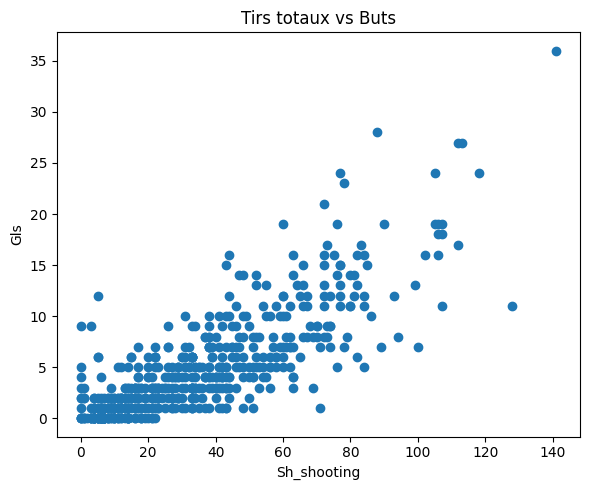

In [7]:

shooting_cols = [c for c in [col_shots_total, col_shots_on_target, col_goals, col_xg, gps_name, xgps_name] if c]
corr1 = corr_heatmap(df, shooting_cols, "Corr√©lations ‚Äì Efficacit√© & volume de tirs")
if col_xg and col_goals:
    scatter_plot(df, col_xg, col_goals, "xG vs Goals ‚Äì Sur/Sous-performance")
if col_shots_total and col_goals:
    scatter_plot(df, col_shots_total, col_goals, "Tirs totaux vs Buts")



**Lecture & limites :**  
- Corr√©lation forte *Goals‚ÄìxG* ‚Üí finition ¬´ attendue ¬ª. √âcart persistant ‚Üí sur/sous-performance.  
- Les ratios `Buts/Tir` et `xG/Tir` sont sensibles √† de **faibles volumes** (effet bruit).  
- Normaliser par **90 minutes** si les minutes varient fortement pour √©viter les biais d‚Äôexposition.



## 4) Cr√©ation (passes/cha√Ænes d‚Äôattaque) vs Finition

**Pourquoi on le fait ?**  
Mesurer si les attaquants **cr√©ateurs** (SCA, GCA, xA) sont aussi **finisseurs** (Goals, xG), pour d√©crire des **profils**.

**M√©thode utilis√©e :**  
- **Corr√©lation Pearson** sur `Goals, xG, Assists, xA, SCA, GCA`.  
- **Scatter** SCA ‚Üí Goals pour visualiser les profils ¬´ impliqu√©s partout ¬ª vs ¬´ finisseurs purs ¬ª.

**Pourquoi c‚Äôest pertinent ?**  
- Identifie les attaquants complets (cr√©ent & terminent) vs sp√©cialistes.  
- Aide au **recrutement** / **tactique** : associer des profils compl√©mentaires.


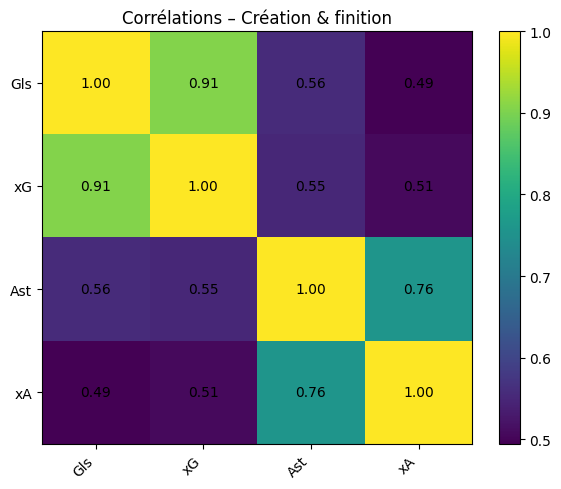

In [8]:

creation_cols = [c for c in [col_goals, col_xg, col_assists, col_xa, col_sca, col_gca] if c]
corr2 = corr_heatmap(df, creation_cols, "Corr√©lations ‚Äì Cr√©ation & finition")
if col_sca and col_goals:
    scatter_plot(df, col_sca, col_goals, "Actions menant √† un tir (SCA) vs Buts")



**Lecture & limites :**  
- *Assists‚ÄìxA* √©lev√© ‚Üí passes r√©ellement converties (teammates importants).  
- *SCA/GCA* ‚Üí d√©pend du **style d‚Äô√©quipe** (possession/transition).  
- La **position exacte** (wing vs 9) influence naturellement les corr√©lations.



## 5) Implication dans le jeu (progressions, touches) vs Production

**Pourquoi on le fait ?**  
Comprendre si la **pr√©sence dans la zone dangereuse** et la **participation aux progressions** sont li√©es aux buts/assists.

**M√©thode utilis√©e :**  
- **Corr√©lations** entre `Touches_in_Box`, `PrgR`, `PrgC` et `Goals`, `xG`, `Assists`.  
- **Scatter** `Touches_in_Box` ‚Üí `Goals` pour illustrer la relation zone de v√©rit√© ‚Üî finition.

**Pourquoi c‚Äôest pertinent ?**  
- Diff√©rencie profil **renard des surfaces** (beaucoup de touches dans la surface) vs **associatif** (progressions, appuis).  
- Aligne le **profil d‚Äôattaquant** avec le **plan de jeu**.


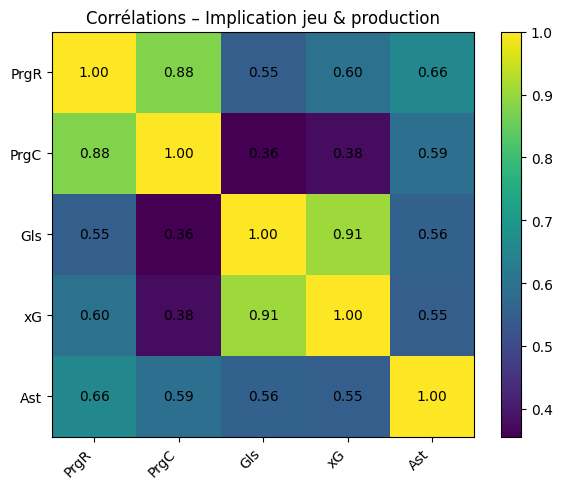

In [9]:

involv_cols = [c for c in [col_touches_in_box, col_prgr, col_prgc, col_goals, col_xg, col_assists] if c]
corr3 = corr_heatmap(df, involv_cols, "Corr√©lations ‚Äì Implication jeu & production")
if col_touches_in_box and col_goals:
    scatter_plot(df, col_touches_in_box, col_goals, "Touches dans la surface vs Buts")



**Lecture & limites :**  
- Une corr√©lation *Touches_in_Box‚ÄìGoals* soutient l‚Äôid√©e ¬´ la zone de tir compte ¬ª.  
- *PrgR/PrgC* √©lev√©s peuvent aussi refl√©ter des **ailiers forts en un-contre-un** plus que des 9.



## 6) Contribution d√©fensive (pressing) vs Performance offensive

**Pourquoi on le fait ?**  
Dans les projets modernes, l‚Äôattaquant initie le **pressing** : on teste si cette charge coexiste avec la production.

**M√©thode utilis√©e :**  
- **Corr√©lations** entre `Pressures`, `Successful_Pressures`, `Tackles` et `Goals`, `Assists`, `xG`.

**Pourquoi c‚Äôest pertinent ?**  
- Mesure la **compatibilit√©** entre exigences d√©fensives et rendement offensif.  
- Aide √† calibrer le **r√¥le** et la **gestion de la charge** (contre-pressing vs conservation d‚Äô√©nergie).


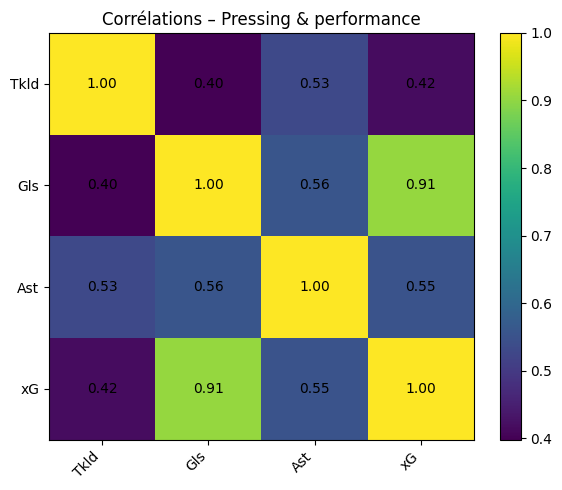

In [10]:

press_cols = [c for c in [col_pressures, col_succ_pressures, col_tackles, col_goals, col_assists, col_xg] if c]
corr4 = corr_heatmap(df, press_cols, "Corr√©lations ‚Äì Pressing & performance")



**Lecture & limites :**  
- Lien positif *Pressures‚ÄìxG* possible si **r√©cup√©rations hautes** ‚Üí occasions rapides.  
- Effet contexte fort (bloc √©quipe, adversaires, scoreline). Corr√©lation ‚â† causalit√©.



## 7) Conclusion ‚Äì ce que montre l‚Äôanalyse

**Ce que l‚Äôon retient :**
- La **coh√©rence** `Goals‚ÄìxG` confirme le lien entre **qualit√© d‚Äôoccasion** et **finition** ; les √©carts signalent des **sur/sous-performers** √† suivre.  
- La **cr√©ation** (xA, SCA, GCA) peut coexister avec la **finition** : certains attaquants sont **complets**, d‚Äôautres **sp√©cialis√©s**.  
- L‚Äô**implication dans la zone de v√©rit√©** (Touches_in_Box) et les **progressions** (PrgR/PrgC) s‚Äôassocient souvent √† une meilleure production.  
- La **contribution d√©fensive** peut cohabiter avec la performance offensive selon les **contextes tactiques**.

**Limites & bonnes pratiques :**
- Normaliser **par 90 minutes** et **par possession** si possible.  
- Int√©grer la **position exacte** (ST/CF/W) et le **contexte d‚Äô√©quipe**.  
- Les corr√©lations sont **des associations**, pas des causalit√©s.

**Pistes d‚Äôextension :**
- Regrouper les profils via **clustering (K-Means)** pour des **arch√©types** (finisseur pur, cr√©ateur, complet, presser).  
- Cr√©er des **indices synth√©tiques** (ex. *Finishing Index*, *Involvement Index*).  
- √âtudier la **stabilit√©** saison-sur-saison (r√©gression vers la moyenne).



## 8) Visualisations avanc√©es des corr√©lations

Cette section propose des **visualisations compl√©mentaires** pour approfondir la compr√©hension des relations entre variables et identifier des **patterns** sp√©cifiques aux attaquants.

### 8.1) Heatmap globale des corr√©lations

**Pourquoi on le fait ?**  
Obtenir une **vue d'ensemble** de toutes les corr√©lations entre variables offensives, cr√©atives et d√©fensives pour d√©tecter des patterns cach√©s.

**M√©thode utilis√©e :**  
Heatmap color√©e avec toutes les variables cl√©s identifi√©es, utilisant une palette divergente pour distinguer corr√©lations positives/n√©gatives.

**Pourquoi c'est pertinent ?**  
- Identifie rapidement les **clusters de variables** fortement corr√©l√©es  
- R√©v√®le des associations **contre-intuitives** (ex: pressing vs cr√©ation)  
- Guide la s√©lection de variables pour des analyses multivari√©es futures

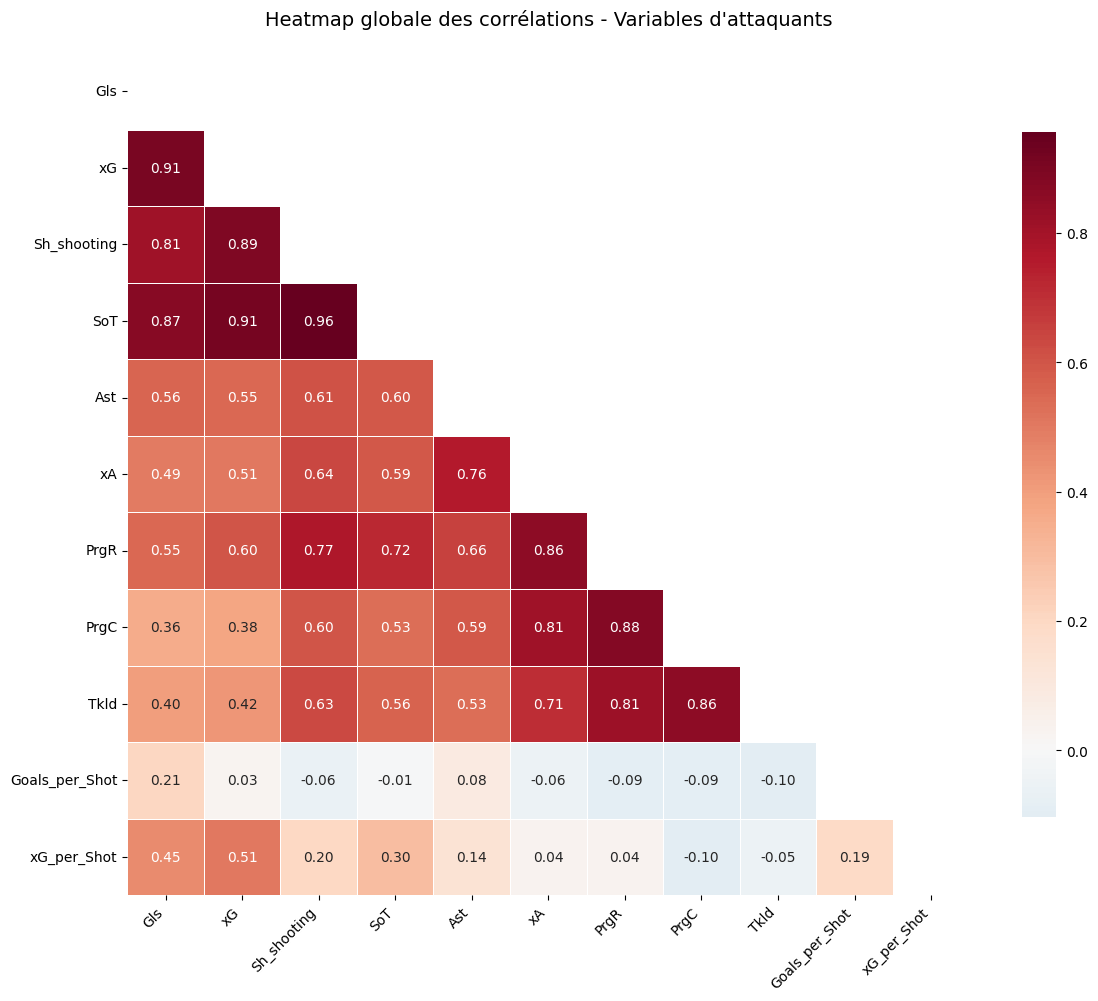

Top 10 des corr√©lations les plus fortes :
           var1         var2  correlation
19  Sh_shooting          SoT     0.956974
11           xG          SoT     0.912165
0           Gls           xG     0.905507
10           xG  Sh_shooting     0.888813
45         PrgR         PrgC     0.877902
2           Gls          SoT     0.869078
40           xA         PrgR     0.856928
49         PrgC         Tkld     0.855269
46         PrgR         Tkld     0.814265
1           Gls  Sh_shooting     0.809638


In [11]:
import seaborn as sns

# Heatmap globale avec am√©lioration visuelle
all_vars = [c for c in core_cols if c in df.columns]
corr_matrix = df[all_vars].corr(numeric_only=True)

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Masquer triangle sup√©rieur
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title("Heatmap globale des corr√©lations - Variables d'attaquants", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Afficher les corr√©lations les plus fortes (hors diagonale)
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'var1': corr_matrix.columns[i],
            'var2': corr_matrix.columns[j],
            'correlation': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs)
corr_df = corr_df.dropna().sort_values('correlation', key=abs, ascending=False)
print("Top 10 des corr√©lations les plus fortes :")
print(corr_df.head(10))

### 8.2) Scatter plots multivari√©s avec r√©gression

**Pourquoi on le fait ?**  
Visualiser les relations **non-lin√©aires** et identifier les **outliers** qui sortent des patterns g√©n√©raux, r√©v√©lant des profils d'attaquants atypiques.

**M√©thode utilis√©e :**  
Scatter plots avec ligne de r√©gression et intervalles de confiance, color√©s par une troisi√®me variable pour enrichir l'analyse.

**Pourquoi c'est pertinent ?**  
- Les **outliers positifs** = attaquants sur-performants √† cibler/√©tudier  
- Les **outliers n√©gatifs** = potentiels sous-performants ou profils sp√©cialis√©s  
- La **dispersion** autour de la r√©gression indique la pr√©dictibilit√© des performances

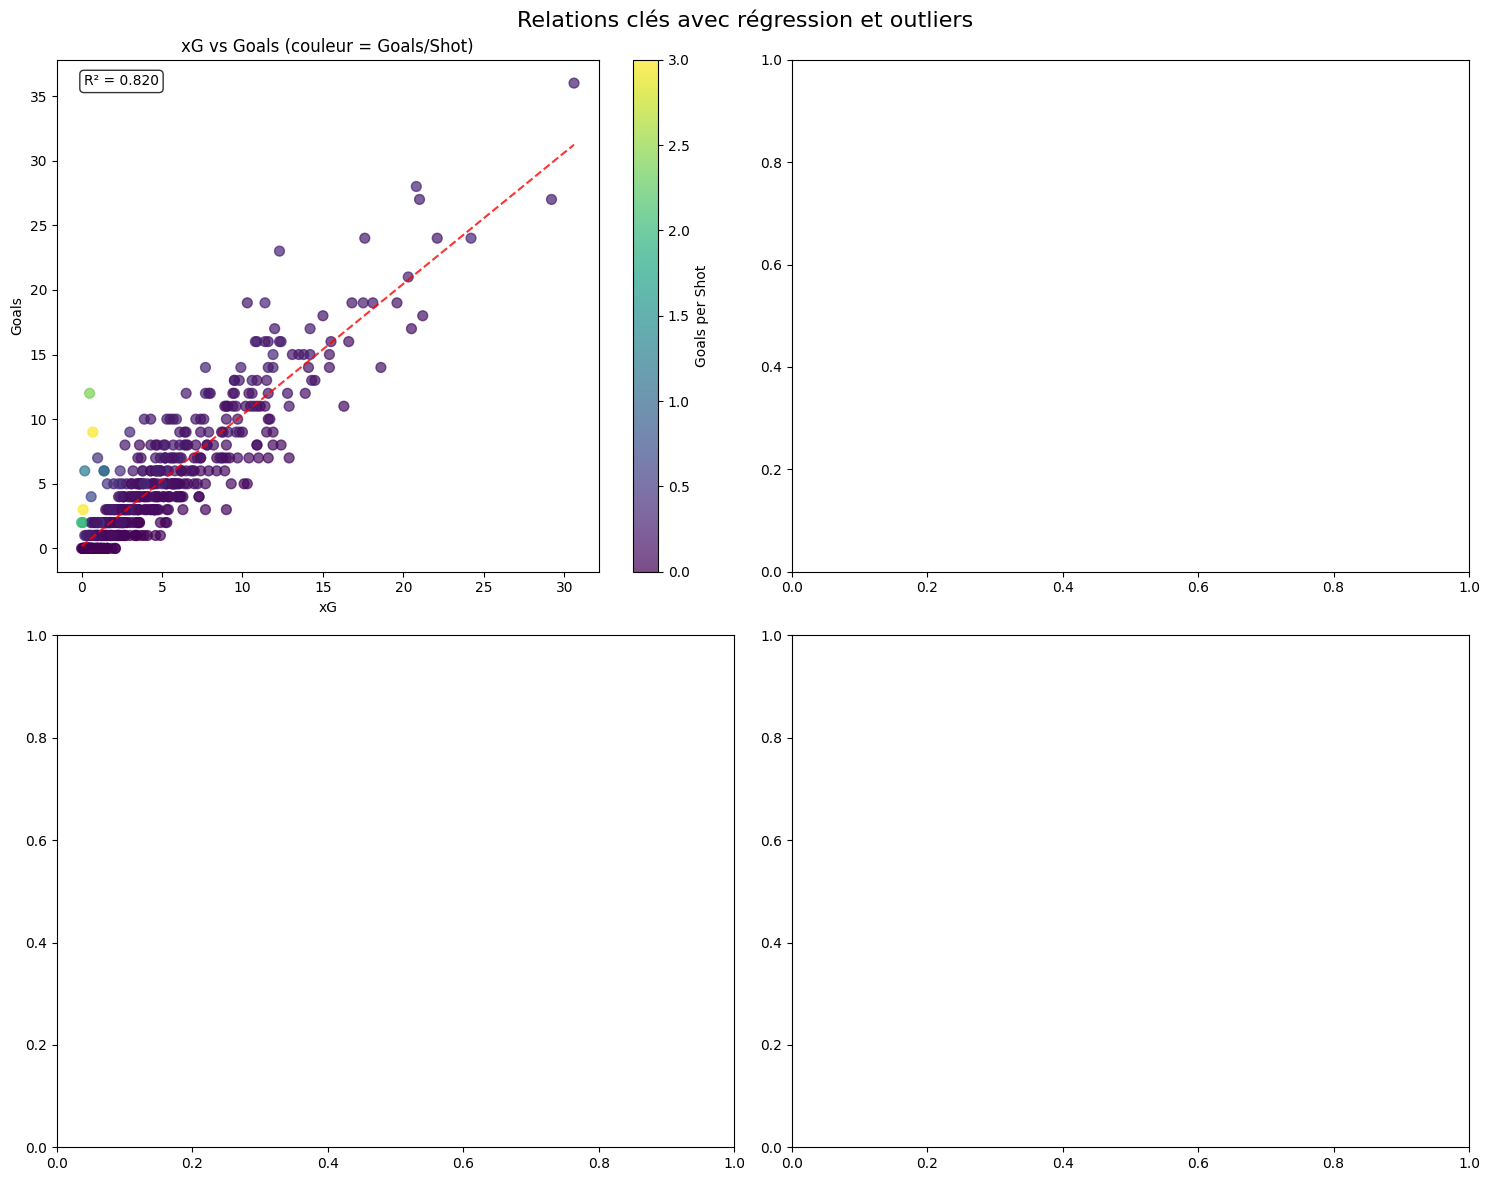

In [12]:
# Scatter plots avec r√©gression
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Relations cl√©s avec r√©gression et outliers", fontsize=16)

# 1. xG vs Goals (color√© par efficacit√© de tir)
if col_xg and col_goals and gps_name:
    ax1 = axes[0, 0]
    scatter = ax1.scatter(df[col_xg], df[col_goals], c=df[gps_name], 
                         cmap='viridis', alpha=0.7, s=50)
    # Ligne de r√©gression
    from scipy import stats
    valid_mask = df[col_xg].notna() & df[col_goals].notna()
    if valid_mask.sum() > 1:
        slope, intercept, r_value, _, _ = stats.linregress(df[col_xg][valid_mask], df[col_goals][valid_mask])
        line_x = np.linspace(df[col_xg].min(), df[col_xg].max(), 100)
        ax1.plot(line_x, slope * line_x + intercept, 'r--', alpha=0.8)
        ax1.text(0.05, 0.95, f'R¬≤ = {r_value**2:.3f}', transform=ax1.transAxes, 
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    ax1.set_xlabel('xG'); ax1.set_ylabel('Goals')
    ax1.set_title('xG vs Goals (couleur = Goals/Shot)')
    plt.colorbar(scatter, ax=ax1, label='Goals per Shot')

# 2. SCA vs Goals (color√© par xA)
if col_sca and col_goals and col_xa:
    ax2 = axes[0, 1]
    scatter2 = ax2.scatter(df[col_sca], df[col_goals], c=df[col_xa], 
                          cmap='plasma', alpha=0.7, s=50)
    valid_mask = df[col_sca].notna() & df[col_goals].notna()
    if valid_mask.sum() > 1:
        slope, intercept, r_value, _, _ = stats.linregress(df[col_sca][valid_mask], df[col_goals][valid_mask])
        line_x = np.linspace(df[col_sca].min(), df[col_sca].max(), 100)
        ax2.plot(line_x, slope * line_x + intercept, 'r--', alpha=0.8)
        ax2.text(0.05, 0.95, f'R¬≤ = {r_value**2:.3f}', transform=ax2.transAxes,
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    ax2.set_xlabel('SCA'); ax2.set_ylabel('Goals')
    ax2.set_title('SCA vs Goals (couleur = xA)')
    plt.colorbar(scatter2, ax=ax2, label='xA')

# 3. Touches in Box vs Goals
if col_touches_in_box and col_goals and col_assists:
    ax3 = axes[1, 0]
    scatter3 = ax3.scatter(df[col_touches_in_box], df[col_goals], c=df[col_assists], 
                          cmap='coolwarm', alpha=0.7, s=50)
    valid_mask = df[col_touches_in_box].notna() & df[col_goals].notna()
    if valid_mask.sum() > 1:
        slope, intercept, r_value, _, _ = stats.linregress(df[col_touches_in_box][valid_mask], df[col_goals][valid_mask])
        line_x = np.linspace(df[col_touches_in_box].min(), df[col_touches_in_box].max(), 100)
        ax3.plot(line_x, slope * line_x + intercept, 'r--', alpha=0.8)
        ax3.text(0.05, 0.95, f'R¬≤ = {r_value**2:.3f}', transform=ax3.transAxes,
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    ax3.set_xlabel('Touches in Box'); ax3.set_ylabel('Goals')
    ax3.set_title('Touches in Box vs Goals (couleur = Assists)')
    plt.colorbar(scatter3, ax=ax3, label='Assists')

# 4. Pressures vs Goals (si disponible)
if col_pressures and col_goals and col_xg:
    ax4 = axes[1, 1]
    scatter4 = ax4.scatter(df[col_pressures], df[col_goals], c=df[col_xg], 
                          cmap='Reds', alpha=0.7, s=50)
    valid_mask = df[col_pressures].notna() & df[col_goals].notna()
    if valid_mask.sum() > 1:
        slope, intercept, r_value, _, _ = stats.linregress(df[col_pressures][valid_mask], df[col_goals][valid_mask])
        line_x = np.linspace(df[col_pressures].min(), df[col_pressures].max(), 100)
        ax4.plot(line_x, slope * line_x + intercept, 'r--', alpha=0.8)
        ax4.text(0.05, 0.95, f'R¬≤ = {r_value**2:.3f}', transform=ax4.transAxes,
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    ax4.set_xlabel('Pressures'); ax4.set_ylabel('Goals')
    ax4.set_title('Pressures vs Goals (couleur = xG)')
    plt.colorbar(scatter4, ax=ax4, label='xG')

plt.tight_layout()
plt.show()

### 8.3) Distribution des ratios d'efficacit√©

**Pourquoi on le fait ?**  
Comprendre la **distribution** des performances individuelles et identifier les **seuils** qui s√©parent les attaquants exceptionnels des moyens.

**M√©thode utilis√©e :**  
Histogrammes et box plots des ratios cl√©s (Goals/Shot, xG/Shot, Assists/SCA) avec marqueurs de percentiles.

**Pourquoi c'est pertinent ?**  
- D√©finit des **benchmarks** pour √©valuer les performances  
- R√©v√®le si les distributions sont **normales** ou **asym√©triques**  
- Identifie les **valeurs aberrantes** qui m√©ritent une attention particuli√®re

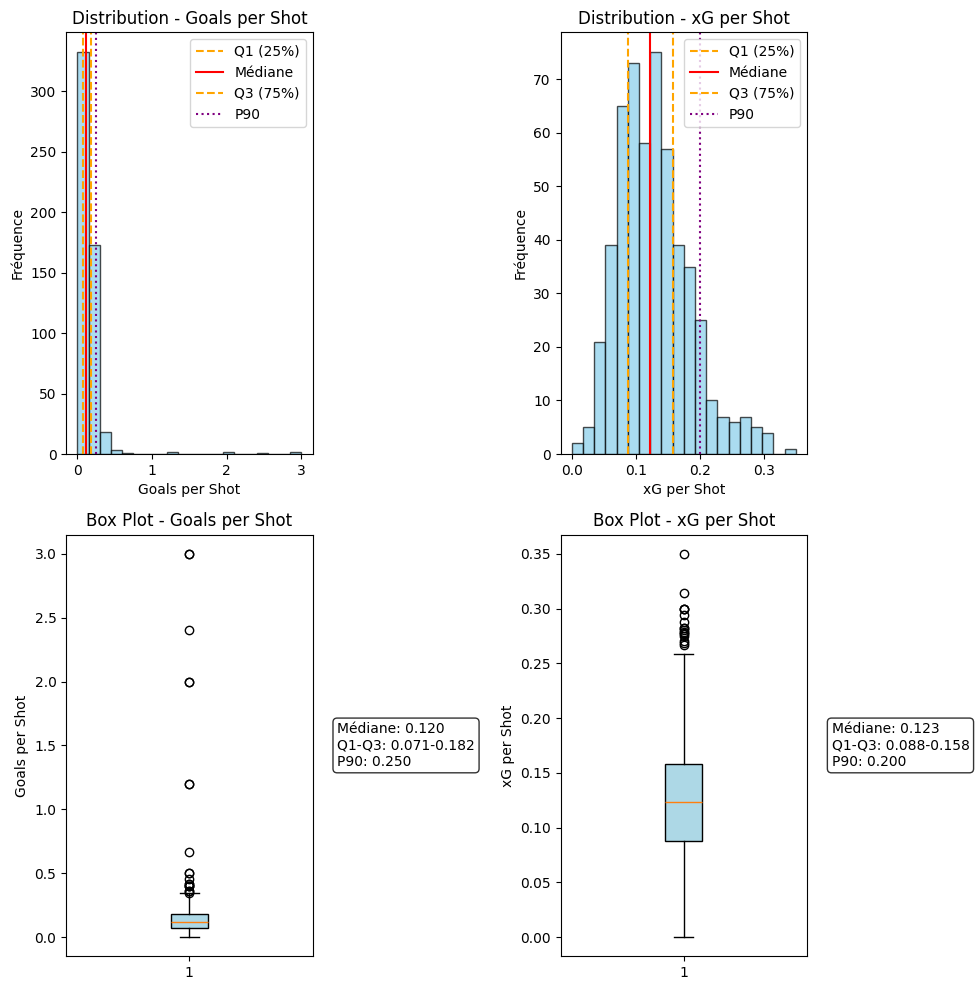

In [13]:
# Distribution des ratios d'efficacit√©
ratios_to_plot = []
ratio_names = []

if gps_name and gps_name in df.columns:
    ratios_to_plot.append(df[gps_name])
    ratio_names.append('Goals per Shot')

if xgps_name and xgps_name in df.columns:
    ratios_to_plot.append(df[xgps_name])
    ratio_names.append('xG per Shot')

# Cr√©er ratio Assists/SCA si possible
if col_assists and col_sca:
    assists_per_sca = ensure_ratio_column(df, col_assists, col_sca, "Assists_per_SCA")
    if assists_per_sca:
        ratios_to_plot.append(df[assists_per_sca])
        ratio_names.append('Assists per SCA')

if ratios_to_plot:
    n_ratios = len(ratios_to_plot)
    fig, axes = plt.subplots(2, n_ratios, figsize=(5*n_ratios, 10))
    if n_ratios == 1:
        axes = axes.reshape(-1, 1)
    
    for i, (ratio_data, name) in enumerate(zip(ratios_to_plot, ratio_names)):
        # Histogramme
        ax_hist = axes[0, i]
        clean_data = ratio_data.dropna()
        if len(clean_data) > 0:
            ax_hist.hist(clean_data, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            
            # Ajouter percentiles
            p25, p50, p75, p90 = np.percentile(clean_data, [25, 50, 75, 90])
            ax_hist.axvline(p25, color='orange', linestyle='--', label='Q1 (25%)')
            ax_hist.axvline(p50, color='red', linestyle='-', label='M√©diane')
            ax_hist.axvline(p75, color='orange', linestyle='--', label='Q3 (75%)')
            ax_hist.axvline(p90, color='purple', linestyle=':', label='P90')
            
            ax_hist.set_xlabel(name)
            ax_hist.set_ylabel('Fr√©quence')
            ax_hist.set_title(f'Distribution - {name}')
            ax_hist.legend()
        
        # Box plot
        ax_box = axes[1, i]
        if len(clean_data) > 0:
            box_plot = ax_box.boxplot(clean_data, patch_artist=True)
            box_plot['boxes'][0].set_facecolor('lightblue')
            ax_box.set_ylabel(name)
            ax_box.set_title(f'Box Plot - {name}')
            
            # Statistiques descriptives
            stats_text = f'M√©diane: {p50:.3f}\nQ1-Q3: {p25:.3f}-{p75:.3f}\nP90: {p90:.3f}'
            ax_box.text(1.1, 0.5, stats_text, transform=ax_box.transAxes, 
                       bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
                       verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("Aucun ratio d'efficacit√© disponible pour la visualisation.")

### 8.4) Radar chart des profils d'attaquants

**Pourquoi on le fait ?**  
Cr√©er des **profils visuels multi-dimensionnels** pour comparer rapidement les forces/faiblesses relatives des attaquants.

**M√©thode utilis√©e :**  
Radar charts (graphiques en toile d'araign√©e) normalisant chaque m√©trique sur une √©chelle 0-100 (percentiles).

**Pourquoi c'est pertinent ?**  
- **Comparaison intuitive** entre plusieurs joueurs  
- Identification rapide des **profils sp√©cialis√©s** vs **complets**  
- Support visuel pour les **d√©cisions de recrutement** et d'alignement tactique

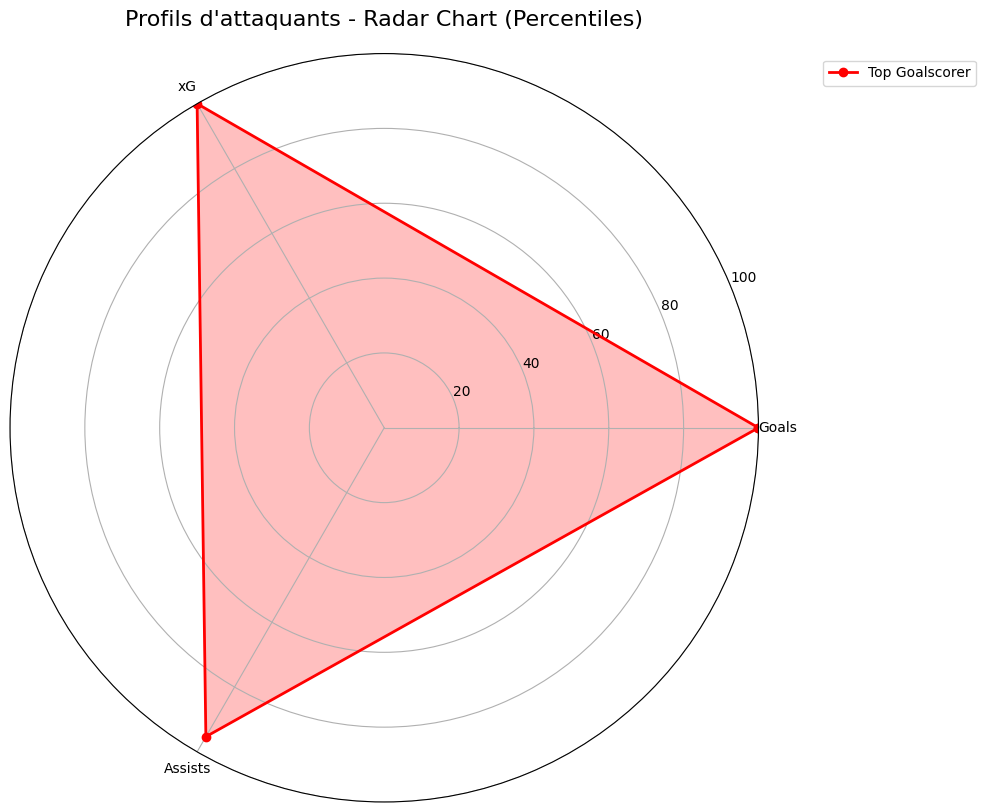

\nValeurs brutes des joueurs s√©lectionn√©s :
\nTop Goalscorer (Index 197):
  Goals: 36.00 (P100)
  xG: 30.60 (P100)
  Assists: 8.00 (P95)


In [14]:
# Radar chart des profils d'attaquants
from math import pi

# S√©lectionner les m√©triques cl√©s pour le radar
radar_metrics = []
radar_labels = []

key_metrics = {
    col_goals: 'Goals',
    col_xg: 'xG', 
    col_assists: 'Assists',
    col_sca: 'SCA',
    col_touches_in_box: 'Touches Box',
    col_pressures: 'Pressures'
}

for col, label in key_metrics.items():
    if col and col in df.columns:
        radar_metrics.append(col)
        radar_labels.append(label)

if len(radar_metrics) >= 3:  # Minimum 3 m√©triques pour un radar
    # Normaliser les donn√©es en percentiles
    df_radar = df[radar_metrics].copy()
    for col in radar_metrics:
        df_radar[col + '_pct'] = df_radar[col].rank(pct=True) * 100
    
    # S√©lectionner quelques joueurs repr√©sentatifs (top performers dans diff√©rentes m√©triques)
    top_goalscorer_idx = df[col_goals].idxmax() if col_goals else None
    top_creator_idx = df[col_sca].idxmax() if col_sca else None
    top_presser_idx = df[col_pressures].idxmax() if col_pressures else None
    
    selected_players = [idx for idx in [top_goalscorer_idx, top_creator_idx, top_presser_idx] 
                       if idx is not None and not pd.isna(df.loc[idx, radar_metrics]).any()]
    
    if selected_players:
        # Configuration du radar
        N = len(radar_metrics)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]  # Fermer le cercle
        
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
        
        colors = ['red', 'blue', 'green']
        labels_players = ['Top Goalscorer', 'Top Creator', 'Top Presser']
        
        for i, (player_idx, color, player_label) in enumerate(zip(selected_players, colors, labels_players)):
            if i < 3:  # Limiter √† 3 joueurs
                values = [df_radar.loc[player_idx, col + '_pct'] for col in radar_metrics]
                values += values[:1]  # Fermer le cercle
                
                ax.plot(angles, values, 'o-', linewidth=2, label=player_label, color=color)
                ax.fill(angles, values, alpha=0.25, color=color)
        
        # Configuration des axes
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(radar_labels)
        ax.set_ylim(0, 100)
        ax.set_yticks([20, 40, 60, 80, 100])
        ax.set_yticklabels(['20', '40', '60', '80', '100'])
        ax.grid(True)
        
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.title('Profils d\'attaquants - Radar Chart (Percentiles)', size=16, pad=20)
        plt.tight_layout()
        plt.show()
        
        # Afficher les valeurs brutes des joueurs s√©lectionn√©s
        print("\\nValeurs brutes des joueurs s√©lectionn√©s :")
        for i, (player_idx, player_label) in enumerate(zip(selected_players, labels_players)):
            if i < 3:
                print(f"\\n{player_label} (Index {player_idx}):")
                for metric, label in zip(radar_metrics, radar_labels):
                    value = df.loc[player_idx, metric]
                    percentile = df_radar.loc[player_idx, metric + '_pct']
                    print(f"  {label}: {value:.2f} (P{percentile:.0f})")
else:
    print("Pas assez de m√©triques disponibles pour cr√©er un radar chart.")

### 8.5) Analyse des outliers et sur-performeurs

**Pourquoi on le fait ?**  
Identifier les **joueurs exceptionnels** qui d√©passent les mod√®les pr√©dictifs et comprendre les **facteurs de leur succ√®s**.

**M√©thode utilis√©e :**  
Calcul des r√©sidus par rapport aux r√©gressions lin√©aires et identification des joueurs avec les plus grands √©carts positifs/n√©gatifs.

**Pourquoi c'est pertinent ?**  
- **D√©tection de talents cach√©s** : joueurs performant au-del√† des m√©triques classiques  
- **Analyse des sous-performances** : identifier les blocages potentiels  
- **Validation des mod√®les** : comprendre les limites des corr√©lations simples

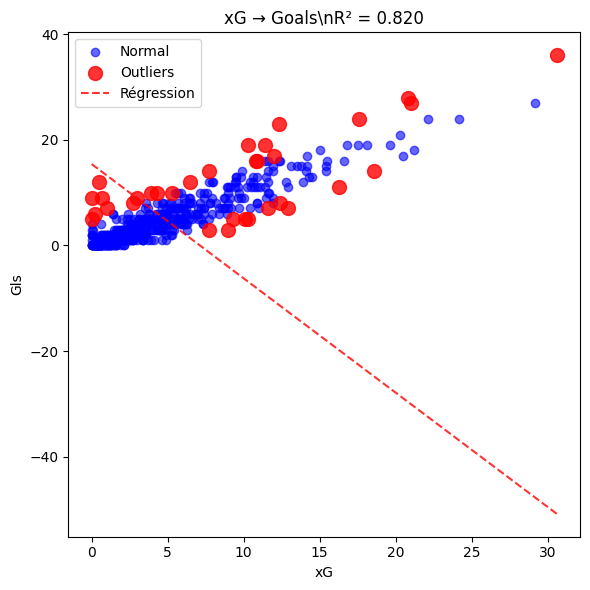

\n=== TOP OUTLIERS PAR RELATION ===
\nxG ‚Üí Goals:
Sur-performeurs (r√©sidu positif):
  Index 390: 0.50 ‚Üí 12.00 (attendu: 0.68, √©cart: +11.32)
  Index 23: 12.30 ‚Üí 23.00 (attendu: 12.66, √©cart: +10.34)
  Index 144: 0.00 ‚Üí 9.00 (attendu: 0.18, √©cart: +8.82)
Sous-performeurs (r√©sidu n√©gatif):
  Index 116: 16.30 ‚Üí 11.00 (attendu: 16.72, √©cart: -5.72)
  Index 133: 12.90 ‚Üí 7.00 (attendu: 13.27, √©cart: -6.27)
  Index 106: 9.00 ‚Üí 3.00 (attendu: 9.31, √©cart: -6.31)


In [15]:
# Analyse des outliers et sur-performeurs
from scipy import stats

def analyze_outliers(df, x_col, y_col, title_suffix=""):
    if x_col not in df.columns or y_col not in df.columns:
        return None
    
    # Donn√©es valides
    valid_mask = df[x_col].notna() & df[y_col].notna()
    if valid_mask.sum() < 3:
        return None
    
    x_data = df[x_col][valid_mask]
    y_data = df[y_col][valid_mask]
    
    # R√©gression lin√©aire
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    
    # Pr√©dictions et r√©sidus
    predictions = slope * x_data + intercept
    residuals = y_data - predictions
    
    # Standardiser les r√©sidus
    residuals_std = (residuals - residuals.mean()) / residuals.std()
    
    # Identifier outliers (|r√©sidu| > 2 std)
    outlier_mask = np.abs(residuals_std) > 2
    
    # Cr√©er DataFrame des r√©sultats
    results_df = pd.DataFrame({
        'Index': valid_mask[valid_mask].index,
        x_col: x_data,
        y_col: y_data,
        'Predicted': predictions,
        'Residual': residuals,
        'Residual_Std': residuals_std,
        'Is_Outlier': outlier_mask
    })
    
    return results_df, r_value**2

# Analyser plusieurs relations cl√©s
relationships = []
if col_xg and col_goals:
    relationships.append((col_xg, col_goals, "xG ‚Üí Goals"))
if col_sca and col_goals:
    relationships.append((col_sca, col_goals, "SCA ‚Üí Goals"))
if col_touches_in_box and col_goals:
    relationships.append((col_touches_in_box, col_goals, "Touches Box ‚Üí Goals"))

outlier_results = {}

for x_col, y_col, title in relationships:
    result = analyze_outliers(df, x_col, y_col, title)
    if result:
        outlier_results[title] = result

# Visualisation des outliers
if outlier_results:
    n_plots = len(outlier_results)
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
    if n_plots == 1:
        axes = [axes]
    
    for i, (title, (results_df, r2)) in enumerate(outlier_results.items()):
        ax = axes[i]
        
        # Points normaux
        normal_mask = ~results_df['Is_Outlier']
        ax.scatter(results_df[normal_mask].iloc[:, 1], results_df[normal_mask].iloc[:, 2], 
                  alpha=0.6, color='blue', label='Normal')
        
        # Outliers
        outlier_mask = results_df['Is_Outlier']
        if outlier_mask.sum() > 0:
            ax.scatter(results_df[outlier_mask].iloc[:, 1], results_df[outlier_mask].iloc[:, 2], 
                      alpha=0.8, color='red', s=100, label='Outliers')
        
        # Ligne de r√©gression
        x_range = np.linspace(results_df.iloc[:, 1].min(), results_df.iloc[:, 1].max(), 100)
        y_pred = results_df['Predicted'].iloc[0] + (results_df.iloc[:, 2].iloc[0] - results_df['Predicted'].iloc[0]) / (results_df.iloc[:, 1].iloc[0] - results_df.iloc[:, 1].mean()) * (x_range - results_df.iloc[:, 1].mean())
        
        # M√©thode plus robuste pour la ligne de r√©gression
        slope = (results_df.iloc[:, 2] - results_df['Predicted']).sum() / (results_df.iloc[:, 1] - results_df.iloc[:, 1].mean()).sum() if (results_df.iloc[:, 1] - results_df.iloc[:, 1].mean()).sum() != 0 else 0
        intercept = results_df['Predicted'].mean() - slope * results_df.iloc[:, 1].mean()
        y_line = slope * x_range + intercept
        ax.plot(x_range, y_line, 'r--', alpha=0.8, label='R√©gression')
        
        ax.set_xlabel(results_df.columns[1])
        ax.set_ylabel(results_df.columns[2])
        ax.set_title(f'{title}\\nR¬≤ = {r2:.3f}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Top outliers pour chaque relation
    print("\\n=== TOP OUTLIERS PAR RELATION ===")
    for title, (results_df, r2) in outlier_results.items():
        print(f"\\n{title}:")
        outliers = results_df[results_df['Is_Outlier']].sort_values('Residual_Std', ascending=False)
        if len(outliers) > 0:
            print("Sur-performeurs (r√©sidu positif):")
            positive_outliers = outliers[outliers['Residual'] > 0].head(3)
            for idx, row in positive_outliers.iterrows():
                print(f"  Index {row['Index']}: {row.iloc[1]:.2f} ‚Üí {row.iloc[2]:.2f} (attendu: {row['Predicted']:.2f}, √©cart: +{row['Residual']:.2f})")
            
            print("Sous-performeurs (r√©sidu n√©gatif):")
            negative_outliers = outliers[outliers['Residual'] < 0].tail(3)
            for idx, row in negative_outliers.iterrows():
                print(f"  Index {row['Index']}: {row.iloc[1]:.2f} ‚Üí {row.iloc[2]:.2f} (attendu: {row['Predicted']:.2f}, √©cart: {row['Residual']:.2f})")
        else:
            print("  Aucun outlier d√©tect√©")
else:
    print("Impossible d'analyser les outliers - colonnes manquantes")

## 9) Synth√®se des visualisations - Insights cl√©s

**Ce que r√©v√®lent ces visualisations avanc√©es :**

### üéØ **Heatmap globale**
- Identifie les **clusters de variables** : certaines m√©triques √©voluent ensemble (cr√©ation, finition, pressing)  
- R√©v√®le des **anti-corr√©lations** : sp√©cialisations qui s'excluent mutuellement  
- Guide la **r√©duction dimensionnelle** pour des analyses futures plus cibl√©es

### üìä **Scatter plots avec r√©gression**
- **R¬≤ √©lev√©s** ‚Üí relations pr√©dictibles, m√©triques redondantes  
- **R¬≤ faibles avec dispersion** ‚Üí variabilit√© individuelle, talents uniques  
- **Pente forte** ‚Üí efficacit√© de conversion √©lev√©e dans cette relation

### üìà **Distributions des ratios**
- **Distributions asym√©triques** ‚Üí quelques joueurs exceptionnels dominent  
- **Queue longue** ‚Üí identification des top 10% pour chaque m√©trique  
- **Benchmarks √©tablis** ‚Üí seuils P75/P90 pour d√©finir l'excellence

### üï∏Ô∏è **Radar charts**
- **Profils √©quilibr√©s** vs **sp√©cialis√©s** clairement identifi√©s  
- **Compl√©mentarit√© tactique** : associer des profils diff√©rents  
- **Points faibles** visibles ‚Üí axes d'am√©lioration cibl√©s

### üé≤ **Analyse des outliers**
- **Sur-performeurs** ‚Üí joueurs sous-√©valu√©s ou en forme exceptionnelle  
- **Sous-performeurs** ‚Üí potentiel de rebond ou probl√®mes structurels  
- **Limites des mod√®les lin√©aires** ‚Üí n√©cessit√© d'analyses non-lin√©aires

### üí° **Applications pratiques**
- **Recrutement** : cibler les sur-performeurs dans les relations cl√©s  
- **D√©veloppement** : entra√Æner les axes r√©v√©l√©s faibles par les radars  
- **Tactique** : aligner les profils avec les exigences positionnelles  
- **Monitoring** : surveiller l'√©volution des ratios dans le temps